In [3]:
%logstop
%logstart -ortq ~/.logs/PY_Algorithms.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [58]:
import expectexception

# Algorithms

We have learned a bit about how to program in Python and some ways in which we can make our code more Pythonic.  However, programming is not only about making the computer do work for us, its about optimizing the amount of work the computer needs to do.  There are multiple types of work we can consider, but here we will consider three major bottlenecks in code:

1. _Computational Complexity_ - how many instructions are executed?
2. _Memory Needs_ - how much memory is needed?
3. _I/O_ - How many reads and writes or network requests do I need to make?

An *Algorithm* is a procedure for solving a problem.  It describes a sequence of operations then when performed will result in a solution to a problem.  There are many types of algorithms, some are guaranteed find a solution, some do not. Often we are interested in understanding the performance of an algorithm in terms of the three bottlenecks listed above (as well as others).  In order to analyze these algorithms, we need to develop some tools to understand how algorithms behave as a function of the problem size.

## Big O

In order to quantify the complexity of a particular algorithm, we can consider how the algorithm grows with respect to the size of the problem.  For the purposes of this notebook we will only consider problems that are one dimensional, so we can quantify the algorithm with respect to a single number, which we will denote as $N$.  Remember that a problem itself does not have a complexity, rather it is the algorithmic solution which has complexity.  For example, lets consider the problem of summing all the numbers between 1 and $N$ (inclusive).  On way to sum this might be to take the of all of these numbers.

$$ \mathcal{O}(N) $$  

$$ t(n) = a(n^2) + b(n) + c $$

In [4]:
def sum_num(N):
    sum_ = 0
    for n in range(N + 1):
        sum_ += n
    return sum_

In [5]:
sum_num(15)

120

In [6]:
# 1 + 2 + 3 + 4 + 5
sum_num(5)

15

In [7]:
sum_num(6)

21

This algorithm will be $O(N)$ because we need to perform about $N$ operations.  Note that we only care about the dominant function of $N$ in the expansion so for our purposes $O(N) \approx O(N+1) \approx O(2N)$.

However, if we remember think a bit about how numbers sum, we can invoke a summation rule often attributed to Gauss which says that 
$$\sum_{n=1}^{N} n = \frac{N(N+1)}{2}$$

In [8]:
def sum_gauss(N):
    return N*(N+1)//2 # We can use integer division here, why?

In [9]:
sum_gauss(5)

15

In [10]:
sum_gauss(6)

21

This algorithm is $O(1)$ because it does not depend on how the size of $N$!.  Lets just check that it gives the same answer.

In [11]:
for N in range(100):
    assert sum_num(N) == sum_gauss(N)

In [12]:
assert 1 == 1

In [13]:
assert 2 == 2

Now lets plot the time it takes to compute these functions as a function of $N$.  We will use a package called `matplotlib` to do some plotting, don't worry, we will learn about it later!

We will time how long it takes to perform both of these algorithms.  We will take the mean of several runs.

In [14]:
import matplotlib.pyplot as plt
import time

def compute(n_avgs, func, N):
    times = []
    for _ in range(n_avgs):
        ts = time.time()
        func(N)
        times.append(time.time() - ts)
    return sum(times)/float(len(times)) * 1000 # milliseconds

n_avgs = 100
time_sum = []
time_gauss = []
N_range = range(10,100000, 5000)
for N in N_range:
    time_sum.append(compute(n_avgs, sum_num, N))
    time_gauss.append(compute(n_avgs, sum_gauss, N))

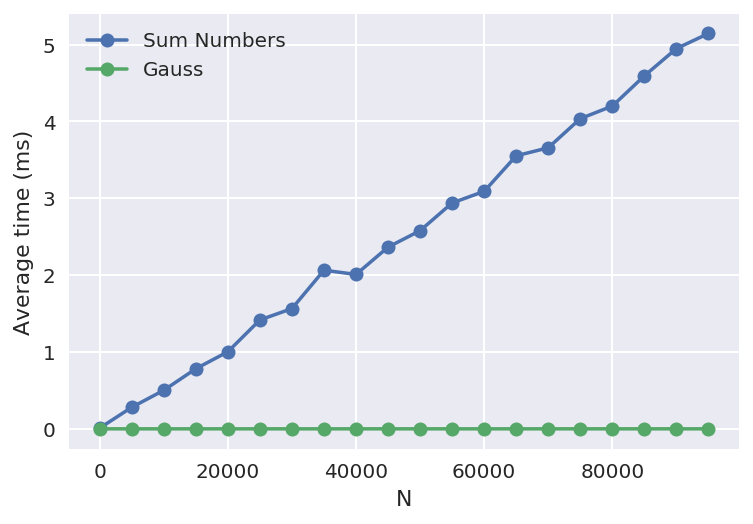

In [15]:
plt.plot(N_range, time_sum, 'o-', label='Sum Numbers')
plt.plot(N_range, time_gauss, 'o-', label='Gauss')
plt.xlabel('N')
plt.ylabel('Average time (ms)')
plt.legend()

## Computational Complexity

Lets solve a version of a common problem you might find as a data scientist, how should I store my data?  Lets take a very simple case where our data is just a list of numbers and we need to store this in a list?  In there any way to optimize the storage?

Lets consider the tradeoffs for various things we might want to do in the list.  

### Finding an element

If we want to find an element in a list and we know nothing about that list, then we need to check every element in the list to see if that element is there.  Lets write a function to do this.

In [16]:
def find_ele(list_, ele):
    for i in list_:
        if i == ele:
            return True
    return False

In order to test these, lets use the `random` module to generate a list of random numbers between $0$ and $10 *N$ where $N$ is the length of the list we want.

In [17]:
import random
def random_list(N, sort=False):
    list_ = [random.randint(0, 10*N) for _ in range(N)]
    return sorted(list_) if sort else list_

In [18]:
random_list(5)

[20, 34, 18, 32, 10]

In [19]:
import numpy as np

def time_func(func, *args):
    ts = time.time()
    func(*args)
    return time.time() - ts

def compute_with_list(n_avgs, N, sort, *funcs):
    ans = []
    for _ in range(n_avgs):
        list_r = random_list(N, sort)
        n_to_find = random.randint(0, 10*N)
        ans.append([time_func(func, list_r, n_to_find)
                for func in funcs])
    # now find avg
    return np.array(ans).mean(axis=0)*1000
    

n_avgs = 40
N_range = range(10, 100000, 10000)
time_list = np.array([compute_with_list(n_avgs, N, False, find_ele) for N in N_range])

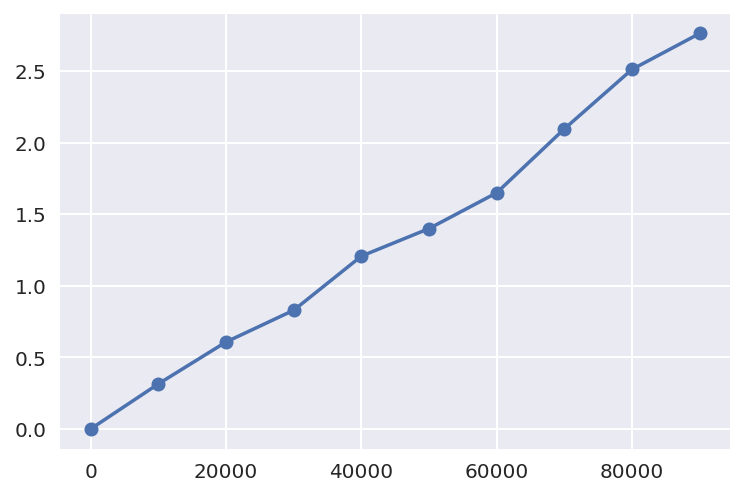

In [20]:
plt.plot(N_range, time_list, 'o-')

Let us take a slightly different approach where we know that this list sorted.  Note that sorting itself is $N\log(N)$ complexity, so although we will be able to perform optimized searches on a sorted list, its not in general faster to sort and then find the elements.  However, if we know we will be searching often, we can build up the list as a sorted structure and for now we can assume that we have already done so.

The most basic optimization we can perform is to only check until we have seen a number greater than what we are looking for.  Since we know the list is sorted, we are guaranteed to not find the number in the rest of the list.

In [21]:
def find_ele_sorted(list_, ele):
    for i in list_:
        if i == ele:
            return True
        if i > ele:
            return False
    return False

n_avgs = 40
N_range = range(10, 100000, 10000)
time_list = np.array([compute_with_list(n_avgs, N, True, find_ele, find_ele_sorted) for N in N_range])

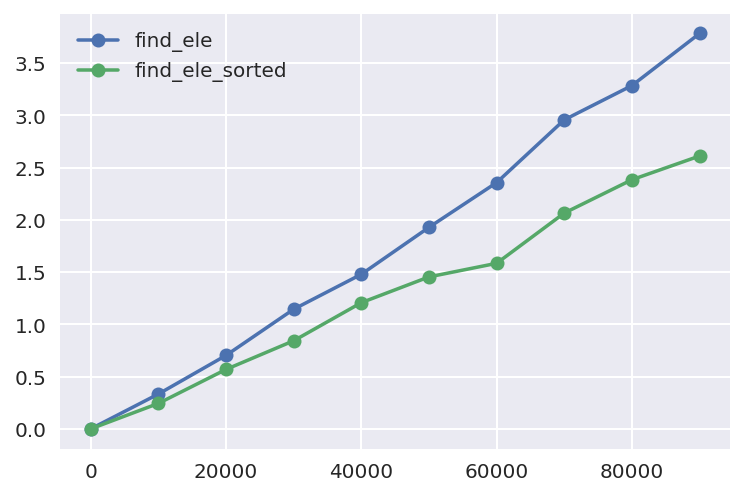

In [22]:
plt.plot(N_range, time_list[:,0], 'o-', label='find_ele')
plt.plot(N_range, time_list[:,1], 'o-', label='find_ele_sorted')
plt.legend()

This does better on average, but it still has the same $O(N)$ runtime.  Such optimizations are useful, but we can do better.  Lets implement what is sometimes known as binary search.  This is a recursive algorithm that allows the list to be divided roughly in half on each recursive step.  this will yield logarithmic asymptotic run time.  Lets first illustrate the algorithm by walking through an example where `l_=[1,2,3,4,5,6,7,8,9,10,11]` and we want to check if 2 is contained in the list.

First we check the midpoint of the list, which is 6.  We know that 2 does not equal 6, but since the list is sorted, we can immediately rule out the part of the list containing numbers greater than 6.  Thus we have already ruled out half the elements of the list. 

Now we can ask the question is 2 contained in list `[1,2,3,4,5]`.  First we check the midpoint element of the list, which is 3.  We know that 3 is not 2, but again, since $3>2$, we can eliminate half the list.

Now we can check if 2 is contained in the list `[1,2]`.  We will take midpoint of this list as the first element (since it has index $1=len(list)/2$), and this is equal to 2.  Thus 2 is in the original list.

We can see we have performed this search in only three steps and up to an extra step, this did not depend on where 2 was in the list, only that it was sorted.  Since we are removing half the list each time, we expect that the number of steps will be roughly $log(N)$, where the logarithm is understood to be base 2.  Lets make a plot of this function compared to $N$.

Text(0, 0.5, '$\\log(x)/x$')

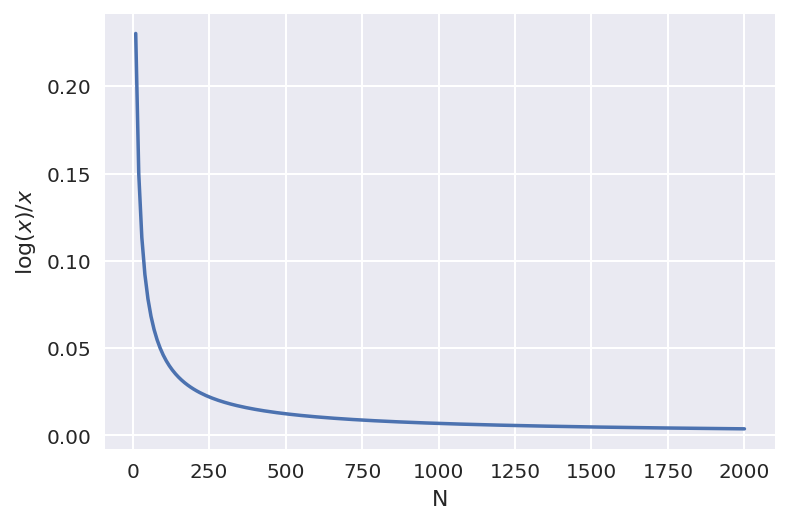

In [23]:
x = np.linspace(10, 2000, 200)
plt.plot(x, np.log(x)/x)
plt.xlabel('N')
plt.ylabel(r'$\log(x)/x$')

Now we can compare this to our other search algorithms.

In [24]:
def find_ele_binary(l_, ele):
    if len(l_) < 1:
        return False
    mid_point = len(l_)//2
    if l_[mid_point] == ele:
        return True
    elif l_[mid_point] > ele:
        return find_ele_binary(l_[:mid_point], ele)
    else:
        return find_ele_binary(l_[mid_point+1:], ele)

In [25]:
n_avgs = 50
N_range = np.arange(1000, 70000, 8000)
time_list = np.array([compute_with_list(n_avgs, N, True, find_ele_sorted, find_ele_binary) for N in N_range])

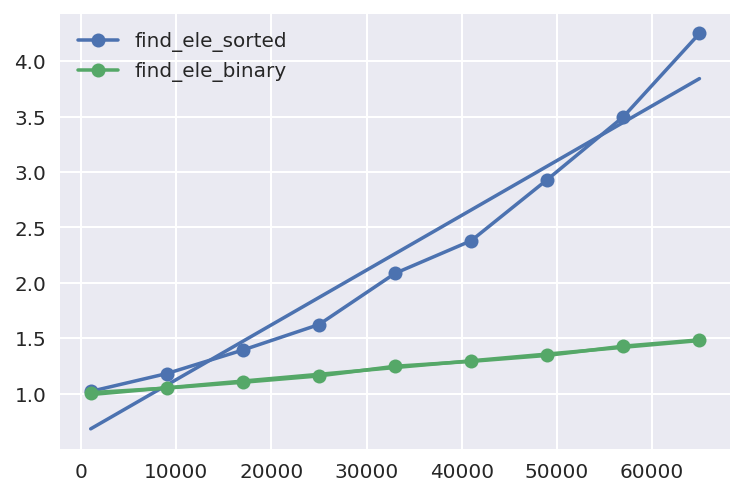

In [26]:
for i, func in enumerate(['find_ele_sorted', 'find_ele_binary']):
    l, = plt.plot(N_range, 2**time_list[:, i], 'o-', label=func)
    # fit a line to the exponent
    p = np.polyfit(N_range, 2**time_list[:, i], 1)
    plt.plot(N_range, N_range * p[0] + p[1], color=l.get_color())

plt.legend()

Of course, if we are only keeping track of what numbers we have seen, we can use something like a `set` which will be $O(1)$ access.

## Memoization

Often we can get a performance increase just by not recomputing things we have already computed!  Let's look again at our recursive Fibonacci sequence defined in a previous notebook.

In [27]:
def fibonacci_recursive(n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci_recursive(n-1)  + fibonacci_recursive(n-2)

Lets make a slightly different version which keeps track of how many times we call the function on each element.

In [28]:
from collections import defaultdict
def fibonacci_count(n, d):
    d[n] += 1
    if n == 0:
        return 0, d
    elif n == 1:
        return 1, d
    else:
        n1, _ = fibonacci_count(n-1, d)
        n2, _ = fibonacci_count(n-2, d)
        return n1 + n2, d

Lets see this in action for $N=5$. 

In [29]:
N = 5
ans, d = fibonacci_count(N, defaultdict(int))
for i in range(N):
    print(i, d[i])

0 3
1 5
2 3
3 2
4 1



              5
          4       3
         3 2     2 1
       2 1 1 0  1 0
      1 0

Now lets look for $N=25$.

In [30]:
N = 25
ans, d = fibonacci_count(N, defaultdict(int))
print(ans)
for i in range(N):
    print(i, d[i])

75025
0 46368
1 75025
2 46368
3 28657
4 17711
5 10946
6 6765
7 4181
8 2584
9 1597
10 987
11 610
12 377
13 233
14 144
15 89
16 55
17 34
18 21
19 13
20 8
21 5
22 3
23 2
24 1


Notice that we are calling some of these functions with the same argument thousands of time.  If we store the answer to the problem instead of recomputing it, can we do any better?

In [34]:
def fibonacci_mem(n, d):
    if n in d:
        return d[n]
    elif n == 0:
        ans = 0
    elif n == 1:
        ans = 1
    else:
        ans = fibonacci_mem(n-1, d) + fibonacci_mem(n-2, d)
    d[n] = ans
    return ans

In [43]:
fibonacci_mem(32, {0:0, 1:1})

2178309

In [44]:
%%timeit
fibonacci_mem(33, {0:0,1:1})

13.2 µs ± 70.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [45]:
%%timeit
fibonacci_recursive(33)

1.5 s ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
fibonacci_mem(33, {}) == fibonacci_recursive(33)

True

Our memoized solution does much better, it is several orders of magnitude faster than the bare recursive solution.  

However, it does come at a cost, although we save computation, we must use more memory to store the previous result.  Often there will be a tradeoff between the two.

### Exercise

1. Write the factorial function $f(n) = n!$ as a recursive function.
2. Would memoization make this function faster?
3. Now what if we needed to calculate the factorial often (perhaps we were computing probabilities of different selections), would memoization be useful in this case?

## Memory
As seen before memoization has a tradeoff in terms of memory.  Lets try to describe that here for the case of the Fibonacci sequence.  We have to keep track of a single element number (the computed solution) for all number less than $N$, the number we want to compute.  Thus the memory we need grows with problem size as $O(N)$.

We can analyze our algorithms in terms of memory in a similar way.  Again remember, it is the algorithm (and its implementation) which has memory complexity, not the problem itself.  

For our first problem, we will again look at summing the numbers between 0 and $N$, and we will take two different approaches.

For the first we will build a list of these elements and then sum them.

In [52]:
def sum_list(n):
    numbers = range(n)
    return sum(numbers)

In [53]:
%%timeit
sum_list(23)

580 ns ± 9.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [54]:
def sum_iter(n):
    number = 0
    sum_ = 0
    while number < n:
        sum_ += number
        number += 1
    return sum_

In [55]:
%%timeit
sum_iter(23)

1.48 µs ± 17.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [59]:
sum_list(100), sum_iter(100)

(4950, 4950)

## Choose a data structure wisely

As we may have noticed in the sorting section, the type of data structure we use is often tied into our choice of algorithm.  For example, if we don't already have sorted data, we probably don't want to use binary search because we would need to sort the data first and then would negate any search improvement (sorting is worse than $O(N)$).  

This can be mitigated by choosing our original structure wisely, especially when get to build it from raw data.  For example when building a list, inserting elements in a sorted manner can be done in $O(log(N))$ time (with almost the same as binary search).  

Other data structures lend themselves to other algorithmic purposes..  For example, a `heap` (implemented in Python with the [`heapq`](https://docs.python.org/2/library/heapq.html) library) implements a tree like structure which is useful for order statistics, such as keeping track of the largest or smallest $N$ items in a collection.  You can read more about it [here](https://en.wikipedia.org/wiki/Binary_heap).

Even as you work through your miniprojects, sometimes choosing a dictionary instead of a list will be the difference between minutes or seconds of computation.

### Exercises

1. Explain why sorting and then using binary search is slower than just searching.
2. Implement insertion on a list using the same principles as binary search.

Problem solving with Algorithm and Data Structure

### OOP

In [19]:
class Fraction:         # Class Definition
    
    def __init__(self,top,bottom):   # The Constructor
        
        self.num  = top
        self.den  = bottom
        
        # self is a special parameter that will always be used as a reference back to the object itself. It must
        # always be the first formal parameter; however, it will never be given an actual parameter value
        # upon invocation.
my_func = Fraction(4,5)
print(my_func)

In [32]:
# Listing Show Function
def show(self):
    print(self.num, "/", self.den)
    
    my_func = Fraction(4,5)
    my_func.show()

In [30]:
print(my_func)

In [28]:
# Standard Method
def __str__(self):
    return str(self.num) + "/" + str(self.den)
    
my_f =  Fraction(4,5)
print(my_f)

print("I actually got", my_f,  "of the Meat")

my_f.__str__()

str(my_f)

I actually got <__main__.Fraction object at 0x7fb33ba93d68> of the Meat


'<__main__.Fraction object at 0x7fb33ba93d68>'

In [2]:
# Adding Fractions

def __add__(self, other_Fraction):
    new_num = self.num * other_Fraction.den + self.den * other_Fraction.num
    new_den = self.den * other_Fraction.den
    return Fraction(new_num, new_den)

f1 = Fraction(2, 4)
f2 = Fraction(4, 7)
f3 = f1 + f2
print(type(f3))

NameError: name 'Fraction' is not defined

In [49]:
import math
def __add__(self, other_fraction):
    new_num = self.num*other_fraction.den + self.den*other_fraction.num
    new_den = self.den * other_fraction.den
    
    return Fraction(new_num, new_den)
f1 = Fraction(1, 4)
f2 = Fraction(1, 2)
f3 = f1 + f2
print(f3)

TypeError: unsupported operand type(s) for +: 'Fraction' and 'Fraction'

In [48]:
def gcd(m, n):
    while m % n != 0:
        old_m = m
        old_n = n
        m = old_n
        n = old_m % old_n
    return n
print(gcd(20, 10))

10


In [52]:
# Lowest Term Fractions
def __add__(self, other_fraction):
    new_num = self.num*other_fraction.den + self.den*other_fraction.num
    new_den = self.den * other_fraction.den
    
    common = gcd(new_num, new_den)
    return Fraction(new_num // common, new_den // common)

f1 = Fraction(1, 4)
f2 = Fraction(3, 7)
f3 = f1 + f2
print(f3)

TypeError: unsupported operand type(s) for +: 'Fraction' and 'Fraction'

In [4]:
# Checking if two fractions are equal

def __eq__(self, other):
    first_num = self.num * other.den
    second_num = other.num * self.den
    return first_num == second_num

In [57]:
# Fraction class
# Implements: addition and equality
# To do: multiplication, division, subtraction and comparison
# operators (< , >)

class Fraction:
    def __init__(self, top, bottom):
        self.num = top
        self.den = bottom
        
    def __str__(self):
        return str(self.num) + "/" + str(self.den)
        
    def show(self):
        print(self.num, "/", self.den)
        
    def __add__(self, other_fraction):
        new_num = self.num * other_fraction.den + \
        self.den * other_fraction.num
        new_den = self.den * other_fraction.den
        
        common = gcd(new_num, new_den)
        return Fraction(new_num // common, new_den // common)

    def __eq__(self, other):
        first_num = self.num * other.den
        second_num = other.num * self.den
        
        return first_num == second_num
x = Fraction(1, 2)
y = Fraction(2, 3)
print(x + y)
print(x == y)

7/6
False


## Algorithm Analysis

An algorithm is a generic, step-by-step list of instructions for solving a problem.
It is a method for solving any instance of the problem such that given a particular input, the
algorithm produces the desired result

A program, on the other hand, is an algorithm that has
been encoded into some programming language. There may be many programs for the same
algorithm, depending on the programmer and the programming language being used.

In [61]:
# First problem

def sum_of_n(n):
    the_sum = 0
    for i in range(1, n+1):
        the_sum += i
    return the_sum
print (sum_of_n(24))

300


In [63]:
# Second problem

def foo(tom):
    fred = 0
    for bill in range(1, tom+1):
        barn = bill
        fred = fred + barn
    return fred
print(foo(15))

120


The Question is ... If one Function is better than the other... The answer
depends on your criteria. The function sum_of_n is certainly better than the function foo if
you are concerned with readability. 

Algorithm analysis is concerned with comparing algorithms based upon the amount of computing resources that each algorithm uses. We want to be able to consider two algorithms and
say that one is better than the other because it is more efficient in its use of those resources
or perhaps because it simply uses fewer. 

At this point, it is important to think more about what we really mean by computing resources.
There are two different ways to look at this. One way is to consider the amount of space
or memory an algorithm requires to solve the problem. The amount of space required by a
problem solution is typically dictated by the problem instance itself. 

As an alternative to space requirements, we can analyze and compare algorithms based on
the amount of time they require to execute. This measure is sometimes referred to as the
“execution time” or “running time” of the algorithm. One way we can measure the execution
time for the function sum_of_n is to do a benchmark analysis. This means that we will track
the actual time required for the program to compute its result. In Python, we can benchmark a
function by noting the starting time and ending time with respect to the system we are using.

In [67]:
import time

def sum_of_n_2(n):
    start = time.time()
    
    sum_of_n_2 = 0
    for i in range(1, n+1):
        sum_of_n_2 += i

    end = time.time()
    
    return sum_of_n_2,start-end 

In [68]:
sum_of_n_2(12)

(78, -3.5762786865234375e-06)

In [69]:
for i in range(5):
    print("Sum is %d required %10.7f seconds" % sum_of_n_2(10000))

Sum is 50005000 required -0.0007308 seconds
Sum is 50005000 required -0.0005374 seconds
Sum is 50005000 required -0.0005310 seconds
Sum is 50005000 required -0.0005026 seconds
Sum is 50005000 required -0.0005062 seconds


In [70]:
for i in range(5):
    print("Sum is %d required %10.7f seconds" %
sum_of_n_2(1000000))

Sum is 500000500000 required -0.0596361 seconds
Sum is 500000500000 required -0.0551846 seconds
Sum is 500000500000 required -0.0545564 seconds
Sum is 500000500000 required -0.0556600 seconds
Sum is 500000500000 required -0.0585489 seconds


Now consider the following code, which shows a different means of solving the summation
problem. This function, sum_of_n_3, takes advantage of a closed equation 

$$ ∑︀𝑛 𝑖=0 𝑖 = (𝑛)(𝑛+1) 2 $$


In [73]:
def sum_of_n_3(n):
    return (n * (n + 1)) / 2
print(sum_of_n_3(4))

10.0


we do the same benchmark measurement for sum_of_n_3, using five different values for n
(10, 000, 100, 000, 1, 000, 000, 10, 000, 000, and 100, 000, 000), we get the following results:

In [85]:
for i in range(5):
    print("Sum is %d required %10.7f seconds" % sum_of_n_3(10000))

TypeError: not enough arguments for format string

There are two important things to notice about this output. First, the times recorded above are
shorter than any of the previous examples. Second, they are very consistent no matter what the
value of n. It appears that sum_of_n_3 is hardly impacted by the number of integers being
added.


## BIG O Notation

When trying to characterize an algorithm’s efficiency in terms of execution time,independent
of any particular program or computer, it is important to quantify the number of operations or
steps that the algorithm will require. If each of these steps is considered to be a basic unit of
computation, then the execution time for an algorithm can be expressed as the number of steps
required to solve the problem.

* f(n)      Name
* 1         Constant
* log 𝑛     Logarithmic
* 𝑛         Linear
* 𝑛 log 𝑛   Log Linear
* 𝑛**2      Quadratic
* 𝑛**3      Cubic
* 2**𝑛      Exponential

## An Anagram Detection Example

A good example problem for showing algorithms with different orders of magnitude is the
classic anagram detection problem for strings. One string is an anagram of another if the second
is simply a rearrangement of the first. For example, 'heart' and 'earth' are anagrams. The
strings 'python' and 'typhon' are anagrams as well. For the sake of simplicity, we will
assume that the two strings in question are of equal length and that they are made up of symbols
from the set of 26 lowercase alphabetic characters. Our goal is to write a boolean function that
will take two strings and return whether they are anagrams.

** Solution 1 : Checking Off **

Our first solution to the anagram problem will check to see that each character in the first
string actually occurs in the second. If it is possible to “checkoff” each character, then the
two strings must be anagrams. Checking off a character will be accomplished by replacing it
with the special Python value None. However, since strings in Python are immutable, the first
step in the process will be to convert the second string to a list. Each character from the first
string can be checked against the characters in the list and if found, checked off by replacement.

In [94]:
def anagram_solution(s1, s2):
    a_list  = list(s2)
    
    pos1 = 0
    still_ok = True
    
    while pos1 < len(s1) and still_ok:
        pos2 = 0
        found = False
        
        while pos2 < len(a_list) and not found:
            if s1[pos1] == a_list[pos2]:
                found  = True
            else:
                pos2 = pos2 + 1
                
        if found:
            a_list[pos2] = None
        else:
            still_ok = False
            
        pos1 = pos1 + 1
        
    return still_ok

print(anagram_solution('sillians', 'snaillis'))

True


To analyze this algorithm, we need to note that each of the 𝑛 characters in s1 will cause an
iteration through up to 𝑛 characters in the list from s2. Each of the 𝑛 positions in the list will
be visited once to match a character from s1. 

** Solution 2: Sort and Compare **
    
Another solution to the anagram problem will make use of the fact that even though s1 and s2
are different, they are anagrams only if they consist of exactly the same characters. So, if we
begin by sorting each string alphabetically, from a to z, we will end up with the same string if
the original two strings are anagrams. The code below shows this solution. Again, in Python
we can use the built-in sort method on lists by simply converting each string to a list at the
start.


In [95]:
def anagram_solution2(s1, s2):
    a_list1 = list(s1)
    a_list2 = list(s2)
    
    a_list1.sort()
    a_list2.sort()
    
    pos = 0
    matches = True
    
    while pos < len(s1) and matches:
        if a_list1[pos] == a_list2[pos]:
            pos += 1
        else:
            matches = False
    return matches
print(anagram_solution2("basil", "lsiba"))

True


At first glance you may be tempted to think that this algorithm is 𝑂(𝑛), since there is one simple
iteration to compare the 𝑛 characters after the sorting process. However, the two calls to the
Python sort method are not without their own cost. As we will see in a later chapter, sorting
is typically either 𝑂(𝑛
2
) or 𝑂(𝑛 log 𝑛), so the sorting operations dominate the iteration. In the
end, this algorithm will have the same order of magnitude as that of the sorting process.

** Solution 3: Count and Compare **
    
Our final solution to the anagram problem takes advantage of the fact that any two anagrams
will have the same number of a’s, the same number of b’s, the same number of c’s, and so on.
In order to decide whether two strings are anagrams, we will first count the number of times
each character occurs. Since there are 26 possible characters, we can use a list of 26 counters,
one for each possible character. Each time we see a particular character, we will increment the
counter at that position. In the end, if the two lists of counters are identical, the strings must be
anagrams.


In [101]:
def anagram_solution3(s1,s2):
    c1 = [0] * 26
    c2 = [0] * 26
    
    for i in range(len(s1)):
        pos = ord(s1[1]) - ord('a')
        c1[pos] = c1[pos] + 1
        
    for i in range(len(s2)):
        pos = ord(s2[1]) - ord('a')
        c2[pos] = c2[pos] + 1
        
    j = 0
    still_ok = True
    while j < 26 and still_ok:
        if c1[j] == c2[j]:
            j += 1
        else:
            still_ok = False
            
    return still_ok

print(anagram_solution3("sillians", "lianslis"))

True


Again, the solution has a number of iterations. However, unlike the first solution, none of them
are nested. The first two iterations used to count the characters are both based on 𝑛. The third
iteration, comparing the two lists of counts, always takes 26 steps since there are 26 possible characters in the strings. Adding it all up gives us 𝑇(𝑛) = 2𝑛 + 26 steps. That is 𝑂(𝑛). We
have found a linear order of magnitude algorithm for solving this problem.

In [100]:
ord("a")

97


*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*